# MAKE SURE TO SWITCH TO GPU USING RUNTIME TAB

In [ ]:
# ! git clone https://github.com/experiencor/raccoon_dataset.git

Cloning into 'raccoon_dataset'...
remote: Enumerating objects: 646, done.
remote: Total 646 (delta 0), reused 0 (delta 0), pack-reused 646
Receiving objects: 100% (646/646), 48.00 MiB | 41.62 MiB/s, done.
Resolving deltas: 100% (412/412), done.


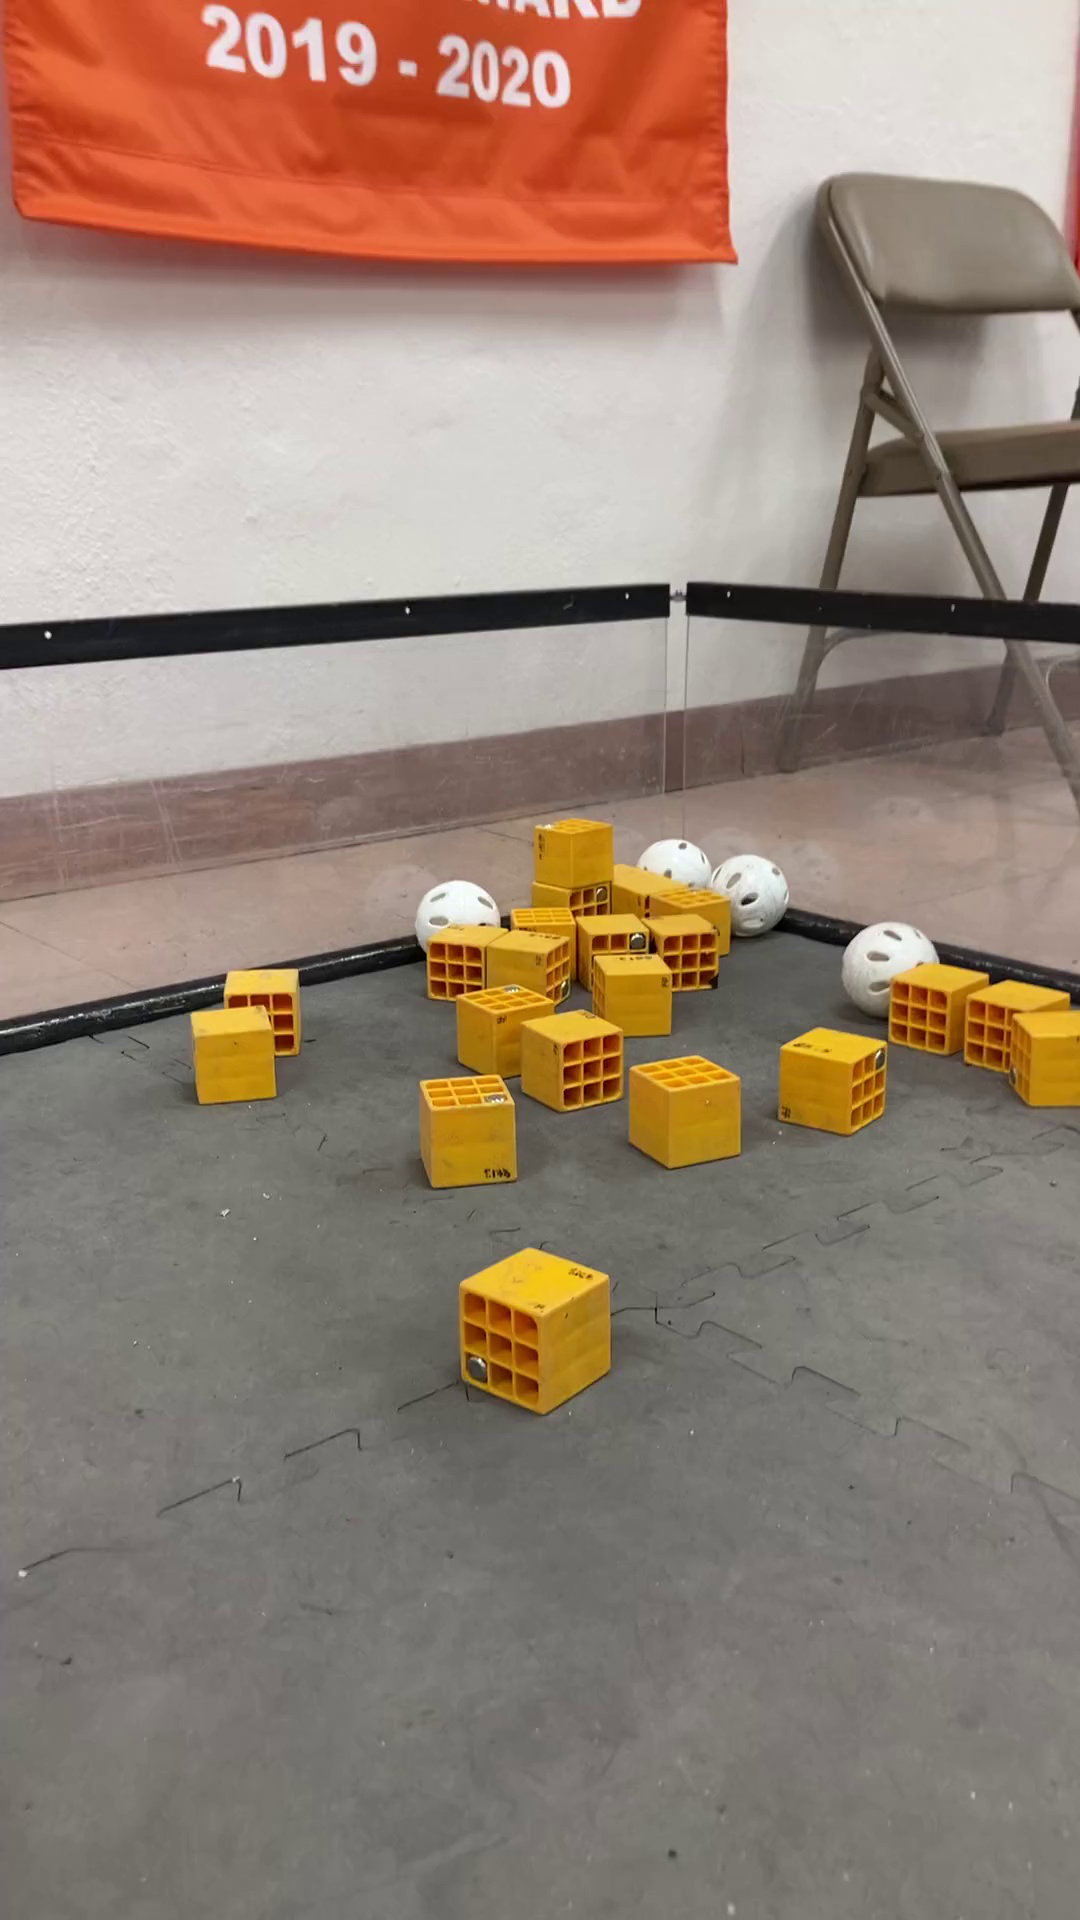

In [3]:
from PIL import Image
from PIL import ImageDraw
import pandas as pd

image = Image.open("./images/image_0.jpg")
image

# images should be 800 * 400

In [6]:
labels = pd.read_csv("./labels.csv", names=["class", "xmin", "ymin", "box_width", "box_height", "filename", "width", "height"])
labels['xmax'] = labels["xmin"] + labels["box_width"]
labels['ymax'] = labels["ymin"] + labels["box_height"]
labels.drop(["box_width", "box_height"], inplace=True, axis=1)
labels.to_csv("./labels.csv")

labels.head()

,class,xmin,ymin,filename,width,height,xmax,ymax
0,box,441,1237,image_0.jpg,1080,1920,628,1431
1,box,156,997,image_0.jpg,1080,1920,297,1124
2,box,198,948,image_0.jpg,1080,1920,335,1061
3,box,392,1067,image_0.jpg,1080,1920,533,1211
4,box,614,1039,image_0.jpg,1080,1920,741,1183


In [8]:
%%bash
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0
cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084d version check against PyTorch's CUDA version


In [9]:
import pycocotools
import numpy as np
import torch
import torch.utils.data
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision
from engine import train_one_epoch, evaluate
import utils
import transforms as T
import os

In [10]:
def parse_one_annot(path_to_data_file, filename):
    data = pd.read_csv(path_to_data_file)
    boxes_array = data[data["filename"] == filename][["xmin", "ymin","xmax", "ymax"]].values
   
    return boxes_array

In [11]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, root, data_file, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(os.listdir(os.path.join(root, "images")))
        self.path_to_data_file = data_file
    def __getitem__(self, idx):
        # load images and bounding boxes
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        box_list = parse_one_annot(self.path_to_data_file, self.imgs[idx])
        boxes = torch.as_tensor(box_list, dtype=torch.float32)
        num_objs = len(box_list)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:,0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target
    def __len__(self):
        return len(self.imgs)

In [12]:
dataset = ImageDataset(root= "./", data_file = "./labels.csv")
dataset.__getitem__(0)

(<PIL.Image.Image image mode=RGB size=1080x1920 at 0x7F36C5644090>,
 {'area': tensor([36278., 17907., 15481., 20304., 18288., 16482.,  9108., 12350.,  8362.,
          15240., 10396., 16440., 10200.]),
  'boxes': tensor([[ 441., 1237.,  628., 1431.],
          [ 156.,  997.,  297., 1124.],
          [ 198.,  948.,  335., 1061.],
          [ 392., 1067.,  533., 1211.],
          [ 614., 1039.,  741., 1183.],
          [ 776., 1015.,  899., 1149.],
          [ 702.,  842.,  801.,  934.],
          [ 839.,  895.,  934., 1025.],
          [ 392.,  874.,  505.,  948.],
          [ 501.,  997.,  628., 1117.],
          [ 522.,  807.,  635.,  899.],
          [ 558.,  934.,  695., 1054.],
          [ 892.,  965.,  977., 1085.]]),
  'image_id': tensor([0]),
  'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])})

In [13]:
def get_model(num_classes):
    # load an object detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new on
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)
   
    return model

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [14]:
# use our dataset and defined transformations
dataset = ImageDataset(root= "./", data_file= "./labels.csv", transforms = get_transform(train=True))
dataset_test = ImageDataset(root= "./", data_file= "./labels.csv", transforms = get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-40])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-40:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0, collate_fn=utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=0, collate_fn=utils.collate_fn)
print("We have: {} examples, {} are training and {} testing".format(len(indices), len(dataset), len(dataset_test)))

We have: 61 examples, 21 are training and 40 testing


In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has three classes: box, hub, and ball
num_classes = 3

# get the model using our helper function
model = get_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by # 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [17]:
# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)

    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/21]  eta: 0:00:10  lr: 0.000255  loss: 0.0204 (0.0204)  loss_classifier: 0.0200 (0.0200)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0004 (0.0004)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.5193  data: 0.1131  max mem: 1639
Epoch: [0]  [10/21]  eta: 0:00:04  lr: 0.002752  loss: 0.0942 (0.1303)  loss_classifier: 0.0567 (0.0577)  loss_box_reg: 0.0000 (0.0399)  loss_objectness: 0.0053 (0.0224)  loss_rpn_box_reg: 0.0000 (0.0104)  time: 0.4478  data: 0.1299  max mem: 1639
Epoch: [0]  [20/21]  eta: 0:00:00  lr: 0.005000  loss: 0.1420 (0.3041)  loss_classifier: 0.0785 (0.1202)  loss_box_reg: 0.0000 (0.1438)  loss_objectness: 0.0127 (0.0217)  loss_rpn_box_reg: 0.0000 (0.0185)  time: 0.3951  data: 0.0948  max mem: 1639
Epoch: [0] Total time: 0:00:08 (0.4012 s / it)
creating index...
index created!
Test:  [ 0/40]  eta: 0:00:10  model_time: 0.1888 (0.1888)  evaluator_time: 0.0167 (0.0167)  time: 0.2632  data: 0.0520  max mem: 1639
Test:  [39/40]  eta: 0:00:00  model_time: 

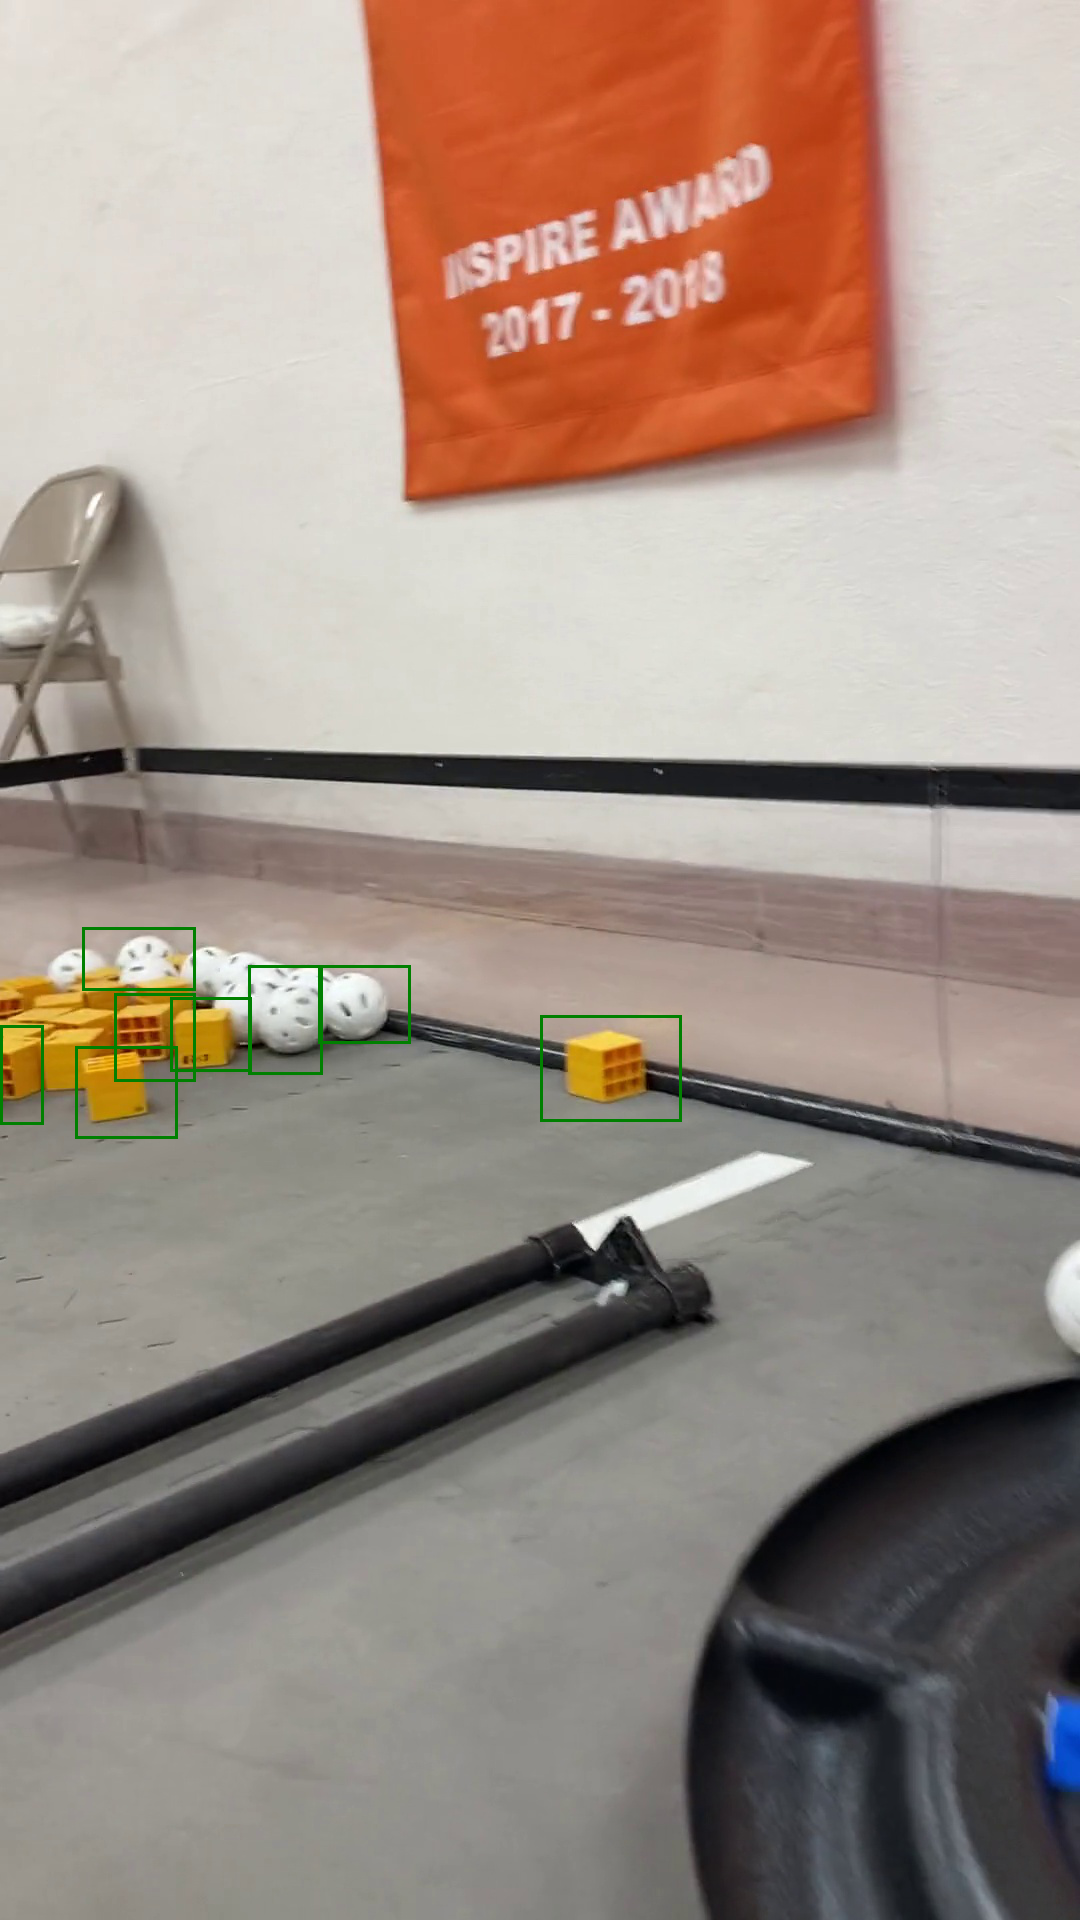

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

idx = 30
img, _ = dataset_test[idx]
label_boxes = np.array(dataset_test[idx][1]["boxes"])

#put the model in evaluation mode
model.eval()

with torch.no_grad():
    prediction = model([img.to(device)])

image = Image.fromarray(img.mul(255).permute(1, 2,0).byte().numpy())
draw = ImageDraw.Draw(image)

# draw groundtruth
for elem in range(len(label_boxes)):
    draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]), (label_boxes[elem][2], label_boxes[elem][3])],  outline ="green", width =3)

for element in range(len(prediction[0]["boxes"])):
    boxes = prediction[0]["boxes"][element].cpu().numpy()
    score = np.round(prediction[0]["scores"][element].cpu().numpy(), decimals= 4)
    if score > 0.8:
        draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], 
        outline ="red", width =3)
        draw.text((boxes[0], boxes[1]), text = str(score))
        
image

In [30]:
# Save Model

torch.save(model.state_dict(), "./model.pth")

In [48]:
# TEST ON RANDOM IMAGE

import requests
image_url = "./images/image_494.jpg"

im = Image.open(image_url)
# im = im.resize((768,1024))

from torchvision import transforms
pil_to_tensor = transforms.ToTensor()(im)

print(pil_to_tensor.shape) 
with torch.no_grad():
  prediction = model([pil_to_tensor.to(device)])

print(prediction)

image = Image.fromarray(pil_to_tensor.mul(255).permute(1, 2,0).byte().numpy())
draw = ImageDraw.Draw(image)

# draw groundtruth (don't do this when using random images)
# for elem in range(len(label_boxes)):
#     draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]), (label_boxes[elem][2], label_boxes[elem][3])],  outline ="green", width =3)

for element in range(len(prediction[0]["boxes"])):
    boxes = prediction[0]["boxes"][element].cpu().numpy()
    score = np.round(prediction[0]["scores"][element].cpu().numpy(), decimals= 4)
    if score > 0.8:
        print(boxes)
        draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], 
        outline ="red", width =3)
        draw.text((boxes[0], boxes[1]), text = str(score))
        
# image

torch.Size([3, 1920, 1080])
[{'boxes': tensor([[ 975.2817,  774.5398, 1068.1279,  909.9993],
        [ 752.3712,  712.1047,  862.8076,  822.2510],
        [ 998.1050,  887.4522, 1076.2648, 1027.7615],
        [ 811.6053,  928.5242,  994.3863, 1092.3990],
        [ 445.8558,  802.1816,  545.9519,  905.5316],
        [ 545.5777,  957.9006,  719.2742, 1125.6930],
        [ 792.2543, 1180.6550, 1023.2763, 1437.0995],
        [ 539.3033,  667.9627,  654.1518,  774.1281],
        [ 420.7757,  716.0212,  541.3129,  915.6356],
        [ 540.7293,  854.3300,  661.5924,  971.0953],
        [ 194.9729,  832.0197,  324.6023, 1039.5814],
        [ 189.8914,  905.7190,  309.7426, 1025.0072],
        [ 657.2769,  702.4096,  763.7804,  774.7659],
        [ 402.3242,  754.1252,  532.8364,  850.0372],
        [ 672.7161,  714.9896,  748.7568,  759.6375],
        [ 682.9880,  817.6852,  792.3887,  916.1255],
        [ 565.2558, 1009.0679,  707.9710, 1106.0587],
        [ 834.3073,  970.3508,  983.2386, 1